# Oregon's Congressional Apportionment 

*Sabi Horvat, June 2021*

## Context:

1. Refer to [April 2021 article](https://towardsdatascience.com/how-to-draw-congressional-districts-in-python-with-linear-programming-b1e33c80bc52) for information about Congressional Districting and motivation for the model.

2. The June 2021 article (link to be added) focuses on comparing the use of Google's open-source [OR-Tools](https://developers.google.com/optimization/assignment/overview) for solving this model, rather than using PuLP.  For this model, the performance of OR-Tools was much better.

## Model Objective and Constraints:

### Decision Variables

- $\text{assignment}_{i,j} \in [0,1]$: Whether the county [ i ] is assigned to the District [ j ]

- $\text{allocation}_{i,j} \in \mathbb{N}_{0}$: The non-negative amount of population from County [ i ] that is allocated to District [ j ]

### Objective Function

- **Assignments**: Minimize the number of counties assigned to districts

\begin{equation}
\text{Minimize} \quad Z = \sum_{(i,j) \in \text{Counties} \times \text{Districts}}{\text{assignment}_{i,j}}
\end{equation}

> Objective notes: In order to satisfy the constraints, all 36 counties must be assigned.  But counties can be assigned to multiple districts, increasing the upper bound of assignments to [36 counties]*[6 districts] = [216 assignments].  Minimizing the number of assignments while still meeting the constraints ensures that there will not be many counties that are split among multiple districts.  Requiring all counties to be assigned to only one district would make the model infeasible given the constraints to ensure the population of each district is close to equal.

### Constraints

- **Allocate all population**: Each county must have exactly all population allocated to districts.

\begin{equation}
\sum_{j \in \text{Districts}}{\text{assignment}_{i,j}} = \text{county_populations}_{i} \quad \forall i \in \text{Counties}
\end{equation}

- **Assignment required for Allocation**: Allocation can only be greater than zero if assignment is greater than zero. 

\begin{equation}
\sum_{(i,j) \in \text{Counties} \times \text{Districts}} {\text{allocation}_{i,j}} \leq \text{M} \times {\text{assignment}_{i,j}}
\end{equation}

- **Completeness Constraints 2 and 3**: All counties may be assigned to up to 1 district, but only counties with a population of at least 84,000 may be assigned to up to 2 districts. 

\begin{equation}
\text{If }  {\text{county_populations}_{i}} \leq \text{84,000 then }
\sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{1}
\quad \forall i \in \text{Counties}
\end{equation}

\begin{equation}
\text{Else } \sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{2}
\end{equation}

- **Contiguous district constraints**: This constraint exists for each county.  For example, county [ 5 ],  Coos County (5) borders only Curry County (7) or Douglas County (8).  Therefore at least (7) or (8) need to be allocated to any district that has (5).

\begin{equation}
\text{assignment}_{5,j} \leq \text{assignment}_{7,j} + \text{assignment}_{9,j} \forall j \in \text{Districts}
\end{equation}

## Table of Contents for Python Optimization Model
1. Import modules
2. Data analysis on population 
3. Optimization model
4. Review solution and making minor changes as necessary.

In [1]:
import geopandas as gpd 
import numpy as np  
import pandas as pd 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

from itertools import product
from ortools.linear_solver import pywraplp
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 

In [2]:
county_id = np.arange(0, 36)
county_names = np.array(['Baker','Benton','Clackamas','Clatsop','Columbia','Coos','Crook','Curry','Deschutes','Douglas','Gilliam','Grant','Harney','Hood River','Jackson','Jefferson','Josephine','Klamath','Lake','Lane','Lincoln','Linn','Malheur','Marion','Morrow','Multnomah','Polk','Sherman','Tillamook','Umatilla','Union','Wallowa','Wasco','Washington','Wheeler','Yamhill']) 
population_by_county = pd.DataFrame({'County_ID': county_id,
                                     'County_Name': county_names,
                                     #2020e from PSU: https://sos.oregon.gov/blue-book/Pages/local/county-population.aspx#InplviewHash04115801-432c-47bf-aef3-abafd774261d=SortField%3DCounty-SortDir%3DAsc
                                     'Population2020e' : [16910,94665,426515,39455,53280,63315,23440,23005,197015,112530,1990,7315,7280,25640,223240,24105,86560,68560,8075,381365,48305,127320,32105,349120,12825,829560,83805,1795,26530,81495,26840,7160,27295,620080,1440,108605],
                                     'Population2010' : [16134,85579,375992,37039,49351,63043,20978,22364,157733,107667,1871,7445,7422,22346,203206,21720,82713,66380,7895,351715,46034,116672,31313,315335,11173,735334,75403,1765,25250,75889,25748,7008,25213,529710,1441,99193],
                                     'Latitude': [44.7346,44.4929,45.3088,46.1068,45.9189,43.175,44.1533,42.6002,43.9856,43.253,45.4204,44.5335,43.2214,45.6007,42.4441,44.4914,42.3351,42.5663,42.7821,44.0123,44.6733,44.4924,43.9454,44.9367,45.4757,45.5437,44.9262,45.4041,45.3957,45.726,45.3181,45.5356,45.3856,45.5404,44.7845,45.2256],
                                     'Longitude': [-117.6777,-123.3844,-122.3999,-123.8773,-122.9863,-124.179,-120.4523,-124.3343,-121.1699,-123.373,-120.2077,-119.0668,-119.0481,-121.7147,-122.7875,-121.3246,-123.5119,-121.6302,-120.4691,-123.1668,-123.9267,-122.7806,-117.484,-122.7301,-119.6694,-122.5346,-123.3237,-120.7307,-123.8622,-118.745,-117.9619,-117.2036,-121.2283,-123.002,-120.02,-123.1982]})
population_by_county['Change2010_2020'] = population_by_county['Population2020e'] - population_by_county['Population2010']

df_county_names = pd.DataFrame(county_names, columns = ['County'])
df = pd.DataFrame()
df['County']  = county_names
df['CountySort'] = county_id

shapefile_oregon = gpd.read_file('data/orcounty.shp')
map_population_by_county_data = shapefile_oregon.merge(population_by_county, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
county_populations = np.array(population_by_county['Population2020e'])
state_population = sum(county_populations)
population_by_county.sort_values('Population2020e', ascending=False).head()

,County_ID,County_Name,Population2020e,Population2010,Latitude,Longitude,Change2010_2020
25,25,Multnomah,829560,735334,45.5437,-122.5346,94226
33,33,Washington,620080,529710,45.5404,-123.0020,90370
2,2,Clackamas,426515,375992,45.3088,-122.3999,50523
19,19,Lane,381365,351715,44.0123,-123.1668,29650
23,23,Marion,349120,315335,44.9367,-122.7301,33785


In [3]:
n_counties = 36
n_districts = 6

## Optimization Model

In [4]:
# Set parameters for the model
population_split = 220000
min_dist = 650000
max_dist = 750000

In [5]:
# Choose the Mixed Integer Program Solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# The amount of demand allocated from DC i to Customer j
x = {}
for i in range(n_counties):
    for j in range(n_districts):
        x[i, j] = solver.NumVar(0, solver.infinity(), 'x')

# 1 if the county has any demand allocated to the district
y = {}    
for i in range(n_counties):
    for j in range(n_districts):
        y[i, j] = solver.IntVar(0, 1, 'y')

# Set the objective to minimize the number of assignments
solver.Minimize(solver.Sum([y[i,j] for i in range(n_counties)
                                   for j in range(n_districts)]))

In [6]:
# Constraints

# Allocate 100% of the population from each county.
for i in range(n_counties):
    solver.Add(solver.Sum([x[i, j] for j in range(n_districts)]) == county_populations[i])

# This constraint makes assignment required for allocation.
# sum(county_populations) is the "big M"
for i in range(n_counties): 
    for j in range(n_districts):
        solver.Add(x[i, j] <= sum(county_populations)*y[i, j])

In [7]:
# Contiguous districts constraints
# e.g. Coos County (5) borders only Curry County (7) or Douglas County (8)
#      Therefore at least (7) or (8) need to be allocated to any district that has (5)
# Optionally, add `2*` to the left hand side so that the county is required to border at least two counties from the same district
for j in range(n_districts):
    solver.Add(y[0, j] <= y[11, j] + y[22, j] + y[30, j] + y[31, j])
    solver.Add(y[1, j] <= y[19, j] + y[20, j] + y[21, j] + y[26, j])
    solver.Add(y[2, j] <= y[13, j] + y[23, j] + y[25, j] + y[32, j] + y[33, j] \
                        + y[35, j])
    solver.Add(y[3, j] <= y[4, j] + y[28, j])
    solver.Add(y[4, j] <= y[3, j] + y[25, j] + y[33, j])
    solver.Add(y[5, j] <= y[7, j] + y[9, j])
    solver.Add(y[6, j] <= y[8, j] + y[11, j] + y[12, j] + y[15, j] + y[34, j])
    solver.Add(y[7, j] <= y[5, j] + y[9, j] + y[16, j])
    solver.Add(y[8, j] <= y[6, j] + y[12, j] + y[15, j] + y[17, j] + y[18, j] \
                        + y[19, j] + y[21, j])
    solver.Add(y[9, j] <= y[5, j] + y[7, j] + y[14, j] + y[16, j] + y[17, j] \
                        + y[19, j])
    solver.Add(y[10, j] <= y[24, j] + y[27, j] + y[32, j] + y[34, j])
    solver.Add(y[11, j] <= y[0, j] + y[6, j] + y[12, j] + y[22, j] + y[24, j] \
                        + y[29, j] + y[30, j] + y[34, j])
    solver.Add(y[12, j] <= y[6, j] + y[8, j] + y[11, j] + y[18, j] + y[22, j])
    solver.Add(y[13, j] <= y[2, j] + y[25, j] + y[32, j])
    solver.Add(y[14, j] <= y[9, j] + y[16, j] + y[17, j])
    solver.Add(y[15, j] <= y[6, j] + y[8, j] + y[21, j] + y[23, j] + y[32, j] \
                        + y[34, j])
    solver.Add(y[16, j] <= y[7, j] + y[9, j] + y[14, j])
    solver.Add(y[17, j] <= y[8, j] + y[9, j] + y[14, j] + y[18, j] + y[19, j])
    solver.Add(y[18, j] <= y[8, j] + y[12, j] + y[17, j])
    solver.Add(y[19, j] <= y[1, j] + y[8, j] + y[9, j] + y[17, j] + y[20, j] \
                        + y[21, j])
    solver.Add(y[20, j] <= y[1, j] + y[19, j] + y[26, j] + y[28, j])
    solver.Add(y[21, j] <= y[1, j] + y[8, j] + y[15, j] + y[19, j] + y[23, j] \
                        + y[26, j])
    solver.Add(y[22, j] <= y[0, j] + y[11, j] + y[12, j])
    solver.Add(y[23, j] <= y[2, j] + y[15, j] + y[21, j] + y[26, j] + y[32, j] \
                        + y[35, j])
    solver.Add(y[24, j] <= y[10, j] + y[11, j] + y[29, j] + y[34, j])
    solver.Add(y[25, j] <= y[2, j] + y[4, j] + y[13, j] + y[33, j])
    solver.Add(y[26, j] <= y[1, j] + y[20, j] + y[21, j] + y[23, j] + y[28, j] \
                        + y[35, j])
    solver.Add(y[27, j] <= y[10, j] + y[32, j])
    solver.Add(y[28, j] <= y[3, j] + y[20, j] + y[26, j] + y[33, j] + y[35, j])
    solver.Add(y[29, j] <= y[11, j] + y[24, j] + y[30, j] + y[31, j])
    solver.Add(y[30, j] <= y[0, j] + y[11, j] + y[29, j] + y[31, j])
    solver.Add(y[31, j] <= y[0, j] + y[29, j] + y[30, j])
    solver.Add(y[32, j] <= y[2, j] + y[10, j] + y[13, j] + y[15, j] + y[23, j] \
                        + y[27, j] + y[34, j])
    solver.Add(y[33, j] <= y[2, j] + y[4, j] + y[25, j] + y[28, j] + y[35, j])
    solver.Add(y[34, j] <= y[6, j] + y[10, j] + y[11, j] + y[15, j] + y[24, j] \
                        + y[32, j])
    solver.Add(y[35, j] <= y[2, j] + y[23, j] + y[26, j] + y[28, j] + y[33, j])


In [8]:
sum(county_populations)/6

711423.3333333334

In [9]:
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    solver.Add(solver.Sum(x[i, j] for i in range(n_counties)) <= max_dist)
    solver.Add(solver.Sum(x[i, j] for i in range(n_counties)) >= min_dist)


In [10]:
# Only allow counties that meet certain critera to be split among multiple districts
# A county must have population > 84,000 to be split among up to two districts
# This constraint reduces the size of the feasible solution space, speeding up the solve time
for i in range(n_counties): # added
    if county_populations[i] <= population_split: 
        solver.Add(solver.Sum(y[i, j] for j in range(n_districts)) <= 1)
    else:
        solver.Add(solver.Sum(y[i, j] for j in range(n_districts)) <= 2) 

In [11]:
# Improvement y / Allocation Constraints (sometimes known as cuts)

# pairs of counties that are far apart geographically with population centers in between them
for j in range(n_districts):
    # East counties not to be assigned to the west beyond population centers in the middle
    # 0, 11, 12, 22, 24, 29, 30, 31
    # Baker (0) on the east not to be assigned to the west beyond population centers in the middle
    solver.Add(y[0, j] + y[1, j] <= 1)
    solver.Add(y[0, j] + y[3, j] <= 1)
    solver.Add(y[0, j] + y[4, j] <= 1)
    solver.Add(y[0, j] + y[5, j] <= 1)
    solver.Add(y[0, j] + y[6, j] <= 1)
    solver.Add(y[0, j] + y[19, j] <= 1) 
    solver.Add(y[0, j] + y[20, j] <= 1)
    solver.Add(y[0, j] + y[21, j] <= 1)
    solver.Add(y[0, j] + y[23, j] <= 1)
    solver.Add(y[0, j] + y[25, j] <= 1)
    solver.Add(y[0, j] + y[26, j] <= 1)
    solver.Add(y[0, j] + y[28, j] <= 1)
    solver.Add(y[0, j] + y[33, j] <= 1)
    solver.Add(y[0, j] + y[35, j] <= 1) 
    # same with Grant (11)
    solver.Add(y[11, j] + y[1, j] <= 1)
    solver.Add(y[11, j] + y[3, j] <= 1)
    solver.Add(y[11, j] + y[4, j] <= 1)
    solver.Add(y[11, j] + y[5, j] <= 1)
    solver.Add(y[11, j] + y[6, j] <= 1)
    solver.Add(y[11, j] + y[19, j] <= 1)
    solver.Add(y[11, j] + y[20, j] <= 1)
    solver.Add(y[11, j] + y[21, j] <= 1)
    solver.Add(y[11, j] + y[23, j] <= 1)
    solver.Add(y[11, j] + y[25, j] <= 1)
    solver.Add(y[11, j] + y[26, j] <= 1)
    solver.Add(y[11, j] + y[28, j] <= 1)
    solver.Add(y[11, j] + y[33, j] <= 1)
    solver.Add(y[11, j] + y[35, j] <= 1)
    # same with Harney (12)
    solver.Add(y[12, j] + y[1, j] <= 1)
    solver.Add(y[12, j] + y[3, j] <= 1)
    solver.Add(y[12, j] + y[4, j] <= 1)
    solver.Add(y[12, j] + y[5, j] <= 1)
    solver.Add(y[12, j] + y[6, j] <= 1)
    solver.Add(y[12, j] + y[19, j] <= 1)
    solver.Add(y[12, j] + y[20, j] <= 1)
    solver.Add(y[12, j] + y[21, j] <= 1)
    solver.Add(y[12, j] + y[23, j] <= 1)
    solver.Add(y[12, j] + y[25, j] <= 1)
    solver.Add(y[12, j] + y[26, j] <= 1)
    solver.Add(y[12, j] + y[28, j] <= 1)
    solver.Add(y[12, j] + y[33, j] <= 1)
    solver.Add(y[12, j] + y[35, j] <= 1)
    # same with Malheur (22)
    solver.Add(y[22, j] + y[1, j] <= 1)
    solver.Add(y[22, j] + y[3, j] <= 1)
    solver.Add(y[22, j] + y[4, j] <= 1)
    solver.Add(y[22, j] + y[5, j] <= 1)
    solver.Add(y[22, j] + y[6, j] <= 1)
    solver.Add(y[22, j] + y[19, j] <= 1)
    solver.Add(y[22, j] + y[20, j] <= 1)
    solver.Add(y[22, j] + y[21, j] <= 1)
    solver.Add(y[22, j] + y[23, j] <= 1)
    solver.Add(y[22, j] + y[25, j] <= 1)
    solver.Add(y[22, j] + y[26, j] <= 1)
    solver.Add(y[22, j] + y[28, j] <= 1)
    solver.Add(y[22, j] + y[33, j] <= 1)
    solver.Add(y[22, j] + y[35, j] <= 1)
    # same with Morrow (24)
    solver.Add(y[24, j] + y[1, j] <= 1)
    solver.Add(y[24, j] + y[3, j] <= 1)
    solver.Add(y[24, j] + y[4, j] <= 1)
    solver.Add(y[24, j] + y[5, j] <= 1)
    solver.Add(y[24, j] + y[6, j] <= 1)
    solver.Add(y[24, j] + y[19, j] <= 1)
    solver.Add(y[24, j] + y[20, j] <= 1)
    solver.Add(y[24, j] + y[21, j] <= 1)
    solver.Add(y[24, j] + y[23, j] <= 1)
    solver.Add(y[24, j] + y[25, j] <= 1)
    solver.Add(y[24, j] + y[26, j] <= 1)
    solver.Add(y[24, j] + y[28, j] <= 1)
    solver.Add(y[24, j] + y[33, j] <= 1)
    solver.Add(y[24, j] + y[35, j] <= 1)
    # same with Umatilla (29)
    solver.Add(y[29, j] + y[1, j] <= 1)
    solver.Add(y[29, j] + y[3, j] <= 1)
    solver.Add(y[29, j] + y[4, j] <= 1)
    solver.Add(y[29, j] + y[5, j] <= 1)
    solver.Add(y[29, j] + y[6, j] <= 1)
    solver.Add(y[29, j] + y[19, j] <= 1)
    solver.Add(y[29, j] + y[20, j] <= 1)
    solver.Add(y[29, j] + y[21, j] <= 1)
    solver.Add(y[29, j] + y[23, j] <= 1)
    solver.Add(y[29, j] + y[25, j] <= 1)
    solver.Add(y[29, j] + y[26, j] <= 1)
    solver.Add(y[29, j] + y[28, j] <= 1)
    solver.Add(y[29, j] + y[33, j] <= 1)
    solver.Add(y[29, j] + y[35, j] <= 1)
    # same with Union (30)
    solver.Add(y[30, j] + y[1, j] <= 1)
    solver.Add(y[30, j] + y[3, j] <= 1)
    solver.Add(y[30, j] + y[4, j] <= 1)
    solver.Add(y[30, j] + y[5, j] <= 1)
    solver.Add(y[30, j] + y[6, j] <= 1)
    solver.Add(y[30, j] + y[19, j] <= 1)
    solver.Add(y[30, j] + y[20, j] <= 1)
    solver.Add(y[30, j] + y[21, j] <= 1)
    solver.Add(y[30, j] + y[23, j] <= 1)
    solver.Add(y[30, j] + y[25, j] <= 1)
    solver.Add(y[30, j] + y[26, j] <= 1)
    solver.Add(y[30, j] + y[28, j] <= 1)
    solver.Add(y[30, j] + y[33, j] <= 1)
    solver.Add(y[30, j] + y[35, j] <= 1)
    # same with Wallowa (31)
    solver.Add(y[31, j] + y[1, j] <= 1)
    solver.Add(y[31, j] + y[3, j] <= 1)
    solver.Add(y[31, j] + y[4, j] <= 1)
    solver.Add(y[31, j] + y[5, j] <= 1)
    solver.Add(y[31, j] + y[6, j] <= 1)
    solver.Add(y[31, j] + y[19, j] <= 1)
    solver.Add(y[31, j] + y[20, j] <= 1)
    solver.Add(y[31, j] + y[21, j] <= 1)
    solver.Add(y[31, j] + y[23, j] <= 1)
    solver.Add(y[31, j] + y[25, j] <= 1)
    solver.Add(y[31, j] + y[26, j] <= 1)
    solver.Add(y[31, j] + y[28, j] <= 1)
    solver.Add(y[31, j] + y[33, j] <= 1)
    solver.Add(y[31, j] + y[35, j] <= 1)
    # southwest counties (5,6,9,19) shouldn't be in the same district as north counties
    # Coos County (5)
    solver.Add(y[5, j] + y[3, j] <= 1)
    solver.Add(y[5, j] + y[4, j] <= 1)
    solver.Add(y[5, j] + y[6, j] <= 1)
    solver.Add(y[5, j] + y[10, j] <= 1)
    solver.Add(y[5, j] + y[11, j] <= 1)
    solver.Add(y[5, j] + y[13, j] <= 1)
    solver.Add(y[5, j] + y[15, j] <= 1)
    solver.Add(y[5, j] + y[24, j] <= 1)
    solver.Add(y[5, j] + y[27, j] <= 1)
    solver.Add(y[5, j] + y[28, j] <= 1)
    solver.Add(y[5, j] + y[32, j] <= 1)
    solver.Add(y[5, j] + y[34, j] <= 1)
    # Curry County (7)
    solver.Add(y[7, j] + y[3, j] <= 1)
    solver.Add(y[7, j] + y[4, j] <= 1)
    solver.Add(y[7, j] + y[6, j] <= 1)
    solver.Add(y[7, j] + y[10, j] <= 1)
    solver.Add(y[7, j] + y[11, j] <= 1)
    solver.Add(y[7, j] + y[13, j] <= 1)
    solver.Add(y[7, j] + y[15, j] <= 1)
    solver.Add(y[7, j] + y[24, j] <= 1)
    solver.Add(y[7, j] + y[27, j] <= 1)
    solver.Add(y[7, j] + y[28, j] <= 1)
    solver.Add(y[7, j] + y[32, j] <= 1)
    solver.Add(y[7, j] + y[34, j] <= 1)
    # Douglas County (9)
    solver.Add(y[9, j] + y[3, j] <= 1)
    solver.Add(y[9, j] + y[4, j] <= 1)
    solver.Add(y[9, j] + y[6, j] <= 1)
    solver.Add(y[6, j] + y[10, j] <= 1)
    solver.Add(y[9, j] + y[11, j] <= 1)
    solver.Add(y[9, j] + y[13, j] <= 1)
    solver.Add(y[9, j] + y[15, j] <= 1)
    solver.Add(y[9, j] + y[24, j] <= 1)
    solver.Add(y[9, j] + y[27, j] <= 1)
    solver.Add(y[9, j] + y[28, j] <= 1)
    solver.Add(y[9, j] + y[32, j] <= 1)
    solver.Add(y[9, j] + y[34, j] <= 1)
    # Lane County (19)
    solver.Add(y[19, j] + y[3, j] <= 1)
    solver.Add(y[19, j] + y[4, j] <= 1)
    solver.Add(y[19, j] + y[6, j] <= 1)
    solver.Add(y[19, j] + y[10, j] <= 1)
    solver.Add(y[19, j] + y[11, j] <= 1)
    solver.Add(y[19, j] + y[13, j] <= 1)
    solver.Add(y[19, j] + y[15, j] <= 1)
    solver.Add(y[19, j] + y[24, j] <= 1)
    solver.Add(y[19, j] + y[27, j] <= 1)
    solver.Add(y[19, j] + y[28, j] <= 1)
    solver.Add(y[19, j] + y[32, j] <= 1)
    solver.Add(y[19, j] + y[34, j] <= 1)
    # northwest counties (3,4,28) shouldn't be in the same district as counties on other side of population centers
    solver.Add(y[3, j] + y[1, j] <= 1)
    solver.Add(y[3, j] + y[6, j] <= 1)
    solver.Add(y[3, j] + y[8, j] <= 1)
    solver.Add(y[3, j] + y[10, j] <= 1)
    solver.Add(y[3, j] + y[21, j] <= 1)
    solver.Add(y[3, j] + y[27, j] <= 1)
    solver.Add(y[4, j] + y[1, j] <= 1)
    solver.Add(y[4, j] + y[6, j] <= 1)
    solver.Add(y[4, j] + y[8, j] <= 1)
    solver.Add(y[4, j] + y[10, j] <= 1)
    solver.Add(y[4, j] + y[21, j] <= 1)
    solver.Add(y[4, j] + y[27, j] <= 1)
    solver.Add(y[28, j] + y[1, j] <= 1)
    solver.Add(y[28, j] + y[6, j] <= 1)
    solver.Add(y[28, j] + y[8, j] <= 1)
    solver.Add(y[28, j] + y[10, j] <= 1)
    solver.Add(y[28, j] + y[21, j] <= 1)
    solver.Add(y[28, j] + y[27, j] <= 1)
    # multnomah (25)
    solver.Add(y[5, j] + y[25, j] <= 1)
    solver.Add(y[6, j] + y[25, j] <= 1)
    solver.Add(y[7, j] + y[25, j] <= 1)
    solver.Add(y[9, j] + y[25, j] <= 1)
    solver.Add(y[10, j] + y[25, j] <= 1)
    solver.Add(y[16, j] + y[25, j] <= 1)
    solver.Add(y[17, j] + y[25, j] <= 1)
    solver.Add(y[18, j] + y[25, j] <= 1)
    solver.Add(y[19, j] + y[25, j] <= 1)
    solver.Add(y[20, j] + y[25, j] <= 1)
    solver.Add(y[21, j] + y[25, j] <= 1)
    solver.Add(y[23, j] + y[25, j] <= 1)
    solver.Add(y[26, j] + y[25, j] <= 1)
    solver.Add(y[27, j] + y[25, j] <= 1)
    solver.Add(y[28, j] + y[25, j] <= 1)
    solver.Add(y[34, j] + y[25, j] <= 1)
    # clackamas (2) 
    solver.Add(y[2, j] + y[5, j] <= 1)
    # these constraints from practice iterations
    solver.Add(y[1, j] + y[6, j] <= 1)
    solver.Add(y[1, j] + y[34, j] <= 1)
    solver.Add(y[3, j] + y[32, j] <= 1)
    solver.Add(y[3, j] + y[34, j] <= 1)
    solver.Add(y[4, j] + y[22, j] <= 1)
    solver.Add(y[4, j] + y[32, j] <= 1)
    solver.Add(y[4, j] + y[34, j] <= 1)
    solver.Add(y[6, j] + y[20, j] <= 1)
    solver.Add(y[7, j] + y[33, j] <= 1)
    solver.Add(y[8, j] + y[26, j] <= 1)
    solver.Add(y[8, j] + y[28, j] <= 1)
    solver.Add(y[8, j] + y[33, j] <= 1)
    solver.Add(y[9, j] + y[28, j] <= 1)
    solver.Add(y[9, j] + y[33, j] <= 1)
    solver.Add(y[10, j] + y[28, j] <= 1)
    solver.Add(y[14, j] + y[28, j] <= 1)
    solver.Add(y[14, j] + y[33, j] <= 1)
    solver.Add(y[16, j] + y[21, j] <= 1)
    solver.Add(y[16, j] + y[33, j] <= 1)
    solver.Add(y[17, j] + y[23, j] <= 1)
    solver.Add(y[17, j] + y[26, j] <= 1)
    solver.Add(y[17, j] + y[33, j] <= 1)
    solver.Add(y[18, j] + y[23, j] <= 1)
    solver.Add(y[18, j] + y[26, j] <= 1)   
    solver.Add(y[18, j] + y[28, j] <= 1)
    solver.Add(y[18, j] + y[33, j] <= 1)
    solver.Add(y[20, j] + y[34, j] <= 1)
    solver.Add(y[24, j] + y[28, j] <= 1)
    solver.Add(y[28, j] + y[29, j] <= 1)

In [12]:
# Solve the model
status = solver.Solve()
# print("Time = ", solver.WallTime(), " milliseconds")

In [13]:
print('Total counties = ', solver.Objective().Value())

Total counties =  37.0


In [14]:
for i in range(n_counties):
    for j in range(n_districts):
        if y[i, j].solution_value() > 0:
#             print('County assigned to district: ', i, j, y[i, j].solution_value())
            print('County %d assigned to district %d: ' % (i, j), x[i, j].solution_value())


County 0 assigned to district 0:  16910.0
County 1 assigned to district 3:  94665.0
County 2 assigned to district 2:  426515.00000000006
County 3 assigned to district 4:  39454.99999999999
County 4 assigned to district 4:  53280.000000000015
County 5 assigned to district 3:  63315.0
County 6 assigned to district 2:  23439.999999999996
County 7 assigned to district 3:  23005.0
County 8 assigned to district 0:  197015.00000000003
County 9 assigned to district 3:  112529.99999999997
County 10 assigned to district 0:  1990.0
County 11 assigned to district 0:  7315.0
County 12 assigned to district 0:  7280.0
County 13 assigned to district 5:  25639.999999999996
County 14 assigned to district 0:  223240.0
County 15 assigned to district 2:  24104.999999999996
County 16 assigned to district 0:  86560.00000000001
County 17 assigned to district 2:  68559.99999999999
County 18 assigned to district 2:  8074.999999999999
County 19 assigned to district 3:  381365.00000000006
County 20 assigned to di

## Create Maps

In [15]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'County': i,
            'District': j+1,
            'Assignment': int(y[i, j].solution_value()*(j+1)),
            'Allocation': x[i, j].solution_value()}
        result_value.append(var_output)

In [16]:
results = pd.DataFrame(result_value)
results = results[results['Assignment'] != 0]
results = results.sort_values(['County', 'District'])
results = results.merge(df, left_on='County', right_on='CountySort',suffixes=('_ID', '_Name'))
results['Multiple_County_Name'] = results['County_Name'].shift(periods=1)
results['Multiple_District'] = results['District'].shift(periods=1).fillna(99).astype(int)

# Edit the assignment for the case when a county has multiple assignments 
for i in range(0,len(results)):
    if results['County_Name'].loc[i] == results['Multiple_County_Name'].loc[i]:
        results.loc[i, 'Assignment'] =   int(str(results['District'].loc[i]) + \
                                                        str(results['Multiple_District'].loc[i]))
results = results.sort_values(['District','County_Name'])
results.index = results['County_ID']

In [17]:
color_dict = { 1 : 'khaki',
               2 : 'pink',
               3 : 'mediumaquamarine',
               4 : 'plum',
               5 : 'paleturquoise',
               6 : 'lightcoral',
               12: 'grey', 13: 'grey', 14: 'grey', 15: 'grey', 16: 'grey',
               21: 'grey', 23: 'grey', 24: 'grey', 25: 'grey', 26: 'grey',
               31: 'grey', 32: 'grey', 34: 'grey', 35: 'grey', 36: 'grey',
               41: 'grey', 42: 'grey', 43: 'grey', 45: 'grey', 46: 'grey',
               51: 'grey', 52: 'grey', 53: 'grey', 54: 'grey', 56: 'grey',
               61: 'grey', 62: 'grey', 63: 'grey', 64: 'grey', 65: 'grey'}

def oregon_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with population labels
    (2) A map with county labels
    (3) A map with county IDs
    """
    
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='Population2020e', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='County_Name_left', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_ids = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='Longitude', y='Latitude', label='County_ID', size=5), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels, plot_map_county_ids


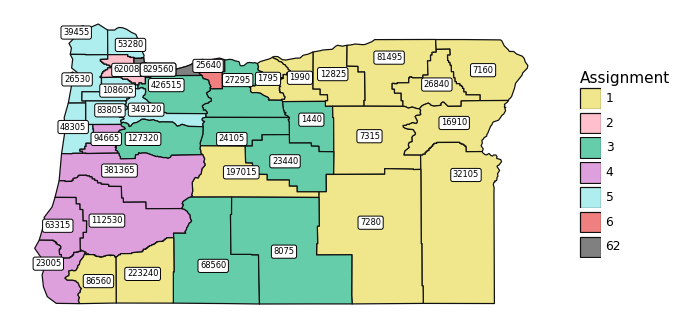

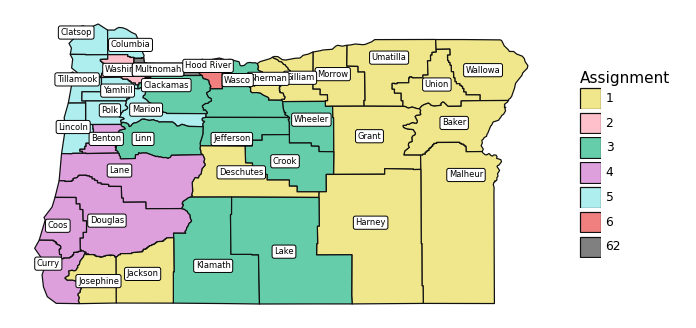

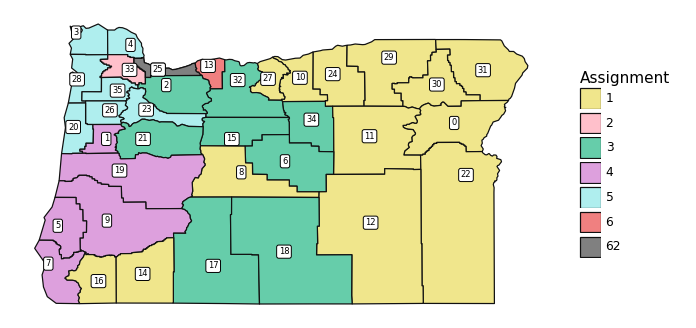

(<ggplot: (8766451872696)>,
 <ggplot: (8766451835621)>,
 <ggplot: (8766451837456)>)

In [18]:
map_first_pass = shapefile_oregon.merge(results, left_on='NAME', right_on='County_Name',
                                        suffixes=('_left', '_right'))
map_first_pass['District'] = map_first_pass['District']+1
map_first_pass_labels = map_first_pass.merge(population_by_county, left_on='County_ID', 
                                             right_on='County_ID',suffixes=('_left','_right'))
map_first_pass_labels['District'] = map_first_pass_labels['District'].astype('category')
map_first_pass_labels['Assignment'] = map_first_pass_labels['Assignment'].astype("category")

oregon_map(map_first_pass_labels)

In [19]:
# Display DataFrame of Counties in Multiple Districts
results[['County_Name','District','Allocation']][results.duplicated(subset=['County_Name'], 
                                                                    keep=False)].sort_values('County_Name')


,County_Name,District,Allocation
County_ID,,,
25,Multnomah,2,105200.0
25,Multnomah,6,724360.0


In [20]:
# Display DataFrame of Total Population by District
district_totals = pd.DataFrame(results.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
district_totals

,Allocation
District,
1,"702,530"
2,"725,280"
3,"706,750"
4,"674,880"
5,"709,100"
6,"750,000"


In [21]:
# Verify that all population was assigned
print('State Population: ', f"{state_population:,.0f}")
pd.DataFrame(results.groupby('District')['Allocation'].sum().astype('int64')).sum()

State Population:  4,268,540


Allocation    4268540
dtype: int64

## Optional - Tweak the Solution
Move a county from one district to another. Then recalculate the solution and remap. The following function only works accurately for counties that are 100% allocated to one county.

In [22]:
# def change_districts(county_to_move, district_to_move_into):
#     """
#     Moves the chosen district into the chosen county.

#     Pass the County ID and the District number as parameters.
#     """
#     results.loc[county_to_move,'Assignment'] = district_to_move_into # for map
#     results.loc[county_to_move,'District'] = district_to_move_into # for sum by district
#     return print('The district has been updated')

In [23]:
# change_districts(17,1)
# change_districts(18,1)
# change_districts(6,1)
# change_districts(27,5)
# change_districts(10,5)
# change_districts(24,5)
# change_districts(29,5)

In [24]:
# # View the tweaked solution numbers
# # Display DataFrame of Total Population by District
# district_totals = pd.DataFrame(results.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
# district_totals

In [25]:
# # View the tweaked solution maps
# map_tweak = shapefile_oregon.merge(results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
# map_tweak['District'] = map_tweak['District']+1
# map_tweak_labels = map_tweak.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
# map_tweak_labels['District'] = map_tweak_labels['District'].astype('category')
# map_tweak_labels['Assignment'] = map_tweak_labels['Assignment'].astype('category')
# oregon_map(map_tweak_labels)